# OpenGOSim

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.stats import norm
from scipy.stats import truncnorm, beta, uniform
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol

import umbridge

### Inputs:

| Variable  | Dimension    | Description |
|----------|-------------|-------------|
| POROSITY|		12 | Distribution below and permeability  is derived directly from this |
| PERMZ   |		1  | PERMZ is normally a fraction of PERMX. 
|         |        | Varies between 1 to 0.01, being the most probable value 0.1.|
| FAULT  |		2  | One parameter per fault. 
|         |        | It should vary between 1 (open) to 0 (completely closed) |
| Heteorgeneity | 1 | Modify the value 0.02.
|         |        | The value can go from 0 to 1 (I would go beyond 0.25).|


|   |            |   |
|----------|:-------------:|------:|
| POROSITY RANGE:|		0.039 |	0.366  |	
| POROSITY MEAN: |		0.2	  |        |	
| POROSITY STD:  |		0.079 |        |


|   |            |
|----------|:-------------:|
| RHI = 0|		Homogeneous reservoir |
| 0.0 < RHI <0.25 |		Slightly heterogeneous reservoir	  |	
| 0.25 < RHI <0.5 |		Heterogeneous reservoir	  |	
| 0.5 < RHI <0.75 |		Very heterogeneous reservoir	  |	
| 0.75 < RHI <1.0 |		Extremely heterogeneous reservoir	  |	
| RHI = 1.0 |		Perfectly heterogeneous reservoir; unlikely this exists	  |	

Other options:
- In the file .in you can modify the aquifer permeability (How fast the aquifer can absorb pressure changes in the system)
- You could vary PERM (1 parameter) between 1 to 1000, being 1 and 1000 quite unlikely.

So we have 12 porosities, 2 faults, 1 aquifer and 1 PERMZ scaling. Totalling 16 parameters to explore.

### Prior distributions:

Let $ \boldsymbol{\theta} \in \mathbb{R}^{16} $
1. Porosity $ \phi(\mathbf{x}) \sim \mathcal{N}_{[0.039, 0.366]}(\mu=0.2, \sigma=0.079) $
2. Permeability ratio (PERMZ) $\sim \text{Beta}_{[0.01, 1]}(\alpha=2, \beta=18) $
3. Fault $\sim \text{Uniform}(0, 1) $
4. Heterogeneity $ \sim \text{Beta}(\alpha=2, \beta=8) $

with joint prior distribution $  \pi(\boldsymbol{\theta})$.


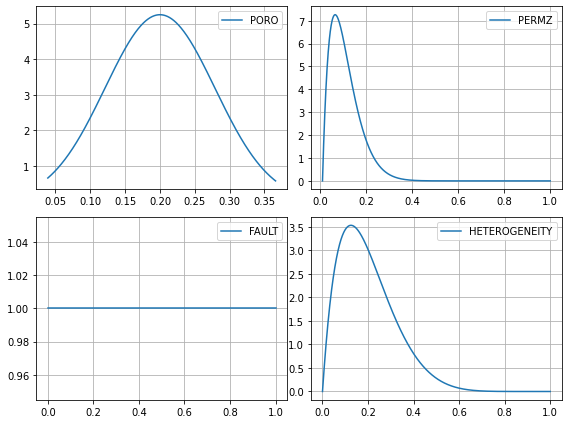

In [2]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

mu = 0.2
sigma = 0.079
lower, upper = 0.039, 0.366
a, b = (lower - mu) / sigma, (upper - mu) / sigma
x_poro = np.linspace(lower, upper, 1000)
pdf_poro = truncnorm.pdf(x_poro, a, b, loc=mu, scale=sigma) # truncated normal
axs[0].plot(x_poro, pdf_poro, label='PORO')

alpha_pz, beta_pz = 2, 18
x_permz = np.linspace(0.01, 1, 1000)
pdf_permz = beta.pdf((x_permz - 0.01) / (1 - 0.01), alpha_pz, beta_pz) / (1 - 0.01)
axs[1].plot(x_permz, pdf_permz, label='PERMZ')

x_fault = np.linspace(0, 1, 1000)
pdf_fault = uniform.pdf(x_fault)
axs[2].plot(x_fault, pdf_fault, label='FAULT')

alpha_h, beta_h = 2, 8
x_het = np.linspace(0, 1, 1000)
pdf_het = beta.pdf(x_het, alpha_h, beta_h)
axs[3].plot(x_het, pdf_het, label='HETEROGENEITY')

for i in range(4):
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

### Outputs
The fields you want to analyse within the -mas.dat/CSV file are the following:
- Field fgit [m^3] : this is the accumulated CO2 injected into the model. The last value of the column is the total injected, you want to inject as much as possible.

The following fields are examples for the coarse model:
- BPressure [bar] 30_30_1
- BPressure [bar] 7_7_1
- BPressure [bar] 27_11_1

These three entries have the pressure at that precise point. You want to make sure that the pressure is not above a maximum threshold. This is 200 Bar. As the model is set up right now, the well will stop injecting if the system goes above 200 Bar so in theory this will never be triggered and the effect of reaching the maximum pressure will be that the total CO2 injected will be diminished. In any case, worth monitoring. Another option is to allow the pressure of the well to go above 200 Bar or set the threshold to be lower (say 190 Bar), up to you.


For the gas reaching the NOGO area you must check the following fields:
- BSgas 7_1_1, BSgas 7_2_1, BSgas 7_3_1,  BSgas 7_4_1, BSgas 7_5_1, BSgas 7_6_1    
- BSgas 7_7_1, BSgas 1_7_1, BSgas 2_7_1,  BSgas 3_7_1, BSgas 4_7_1, BSgas 5_7_1    
- BSgas 6_7_1, BSgas 7_7_1

These provide the saturation of gas at the top cells of the NOGO area

### More on permeability

A correlation between porosity and permeability is used to generate the permeability field using the following formula:

$perm = a b^{poro c -d}$

Potential values for constants:
1. $K = 10^{(15.6 poro - 0.9)}$
2. $K = 0.003 e^{(49 poro)}$

Note that the permeability obtained with these parameters is in mD which is not S.I. units (1 mD = 9.869233e-16 m^2). The permeability is a tensor, not a scalar. Normally, only the three diagonal components are considered and the Kx = Ky and Kz is considered to be a fraction of the others using the kv/kh ratio (vertical/horizontal permeability ratio). Thus, 

$K_z = c K_x$, where $0.01\leq c \leq 0.1$.

### Model

We want to simulate the process of CO2 injection through a porous
medium. Darcy’s Law governs the flow equation.


PFLOTRAN solves the steady-state Darcy flow equation:

$$\nabla \cdot \left( \mathbf{K}(\mathbf{x}, \boldsymbol{\theta}) \nabla p(\mathbf{x}) \right) = q(\mathbf{x})$$

where:
- $\mathbf{x} \in \Omega $: spatial domain
-  $p(\mathbf{x})$: pressure
- $\mathbf{K}(\mathbf{x}, \boldsymbol{\theta})$: uncertain permeability tensor
- $q(\mathbf{x})$: source/sink term



y=M(θ)


M is the PFLOTRAN simulation and y are quantities of interest

- Darcy: https://docs.opengosim.com/theory/mathematical_formulation_of_gw/
- Wells: https://docs.opengosim.com/theory/well_model/

In [61]:
model = umbridge.HTTPModel("http://localhost:4243", "pflotran_simulation")

n_inputs = model.get_input_sizes()[0]
n_outputs = model.get_output_sizes()[0]

print("Number of inputs ", n_inputs)
print("Number of outputs ", n_outputs)

Number of inputs  15
Number of outputs  19


In [68]:
dim = n_inputs
m = 8 # number of samples 2^m
sampler = qmc.Sobol(d=dim, scramble=True)
samples = sampler.random_base2(m=m)

# POROSITY
mean = 0.2
std = 0.079
lower, upper = 0.039, 0.366
a, b = (lower - mean) / std, (upper - mean) / std
porosity_samples = truncnorm.ppf(samples[:, :12], a, b,  loc=mean, scale=std)
samples[:, :12] = porosity_samples

# PERMZ scaling
alpha, beta_param = 2, 18
permz_scaled = beta.ppf(samples[:,12], a=alpha, b=beta_param)
permz_scaled = 0.01 + permz_scaled * (1 - 0.01)
samples[:, 12] = permz_scaled

# FAULTS
samples[:,13] = 1.0*samples[:,13]
samples[:,14] = 1.0*samples[:,14]

print(len(samples))
#for i in range(12):
#    print(max(samples[:,i]))

256


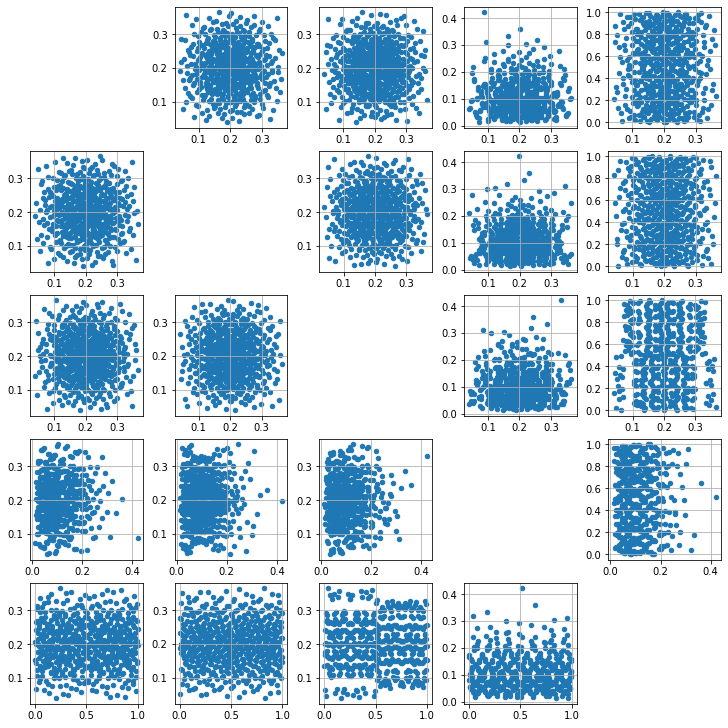

In [67]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10), constrained_layout=True)

for (xi,x_idx) in enumerate([0,1,2,12,13]):
    for (yi,y_idx) in enumerate([0,1,2,12,13]):
        ax = axes[xi, yi]
        if xi == yi:
            ax.set_visible(False)
        else:
            ax.scatter(samples[:, x_idx], samples[:, y_idx], s=20)
            ax.grid(True)
plt.show()

In [70]:
# Expensive bit
def evaluate_samples(samples):
    f = []
    for i in range(len(samples)):
        f.append(model([list(samples[i])]))
        print("Computed sample ", i)
    return np.array(f)
feval = evaluate_samples(samples)

with open('opengosim_in.pkl', 'wb+') as f:
    pickle.dump(samples, f)
with open('opengosim_out.pkl', 'wb+') as f:
    pickle.dump(feval, f)

In [64]:
with open('opengosim_in.pkl', 'rb') as f:
    samples = pickle.load(f)
with open('opengosim_out.pkl', 'rb') as f:
    feval = pickle.load(f)
    
mean_estimate = np.mean(feval, axis=0)
print("Mean estimate:", mean_estimate)

var_estimate = np.var(feval, axis=0)
print("Variance estimate:", var_estimate)

Mean estimate: [7.96800242e+08 1.33717929e+02 1.31055884e+02 1.35079271e+02
 2.14733633e-01 2.38188548e-01 2.69661715e-01 3.02929161e-01
 3.38691731e-01 3.78983036e-01 4.21142232e-01 2.98084841e-01
 3.01601928e-01 3.13736909e-01 3.32608168e-01 3.57686165e-01
 3.87601233e-01 4.21142232e-01]
Variance estimate: [5.71060312e+14 2.32114597e-01 2.66906510e-01 5.93425990e-01
 1.04311892e-01 1.06781975e-01 1.11866845e-01 1.15504614e-01
 1.16283681e-01 1.14270385e-01 1.09522848e-01 1.23070963e-01
 1.21728963e-01 1.21087916e-01 1.19727988e-01 1.17666916e-01
 1.14910512e-01 1.09522848e-01]
2035


#### First check for values exceeding thresholds

- Check if any pressure exceeds 200bar
- Check for gas in the no go areas

In [51]:
invalid_flags = []
# Check if any pressure exceeds 200bar
output_pressure = [feval[i][1:4] for i in range(len(feval))]
for (idx,f) in enumerate(output_pressure):
    if np.any([px >= 200 for px in f]):
            print("Sample", samples[idx] , " at pressure ", f, "exceeds 200 bar")
            invalid_flags.append(1)
    else:
        invalid_flags.append(0)

In [52]:
# Check gas in NOGO area
output_gas = [feval[i][4:-1] for i in range(len(samples))]

s = 0
for (idx,f) in enumerate(output_gas):
    if np.sum([px for px in f]) > 0.0:
        #print("Sample ", it, " has ", sum([px for px in f]) , " gas in NOGO area")
        invalid_flags[idx] = 1
        s = s+1
        
print("Number of samples with gas ", s)

Number of samples with gas  1416


#### Get an impression of inputs vs. injected gas

- Double check distributions over inputs are as expected
- Plot output distribution

In [36]:
import seaborn as sns
import pandas as pd

param_names = [f'poro_{i}' for i in range(12)] + ['permz', 'fault_1', 'fault_2']
df = pd.DataFrame(samples, columns=param_names)
df['injected_gas'] = [feval[i][0] for i in range(len(samples))]
df['invalid'] = invalid_flags

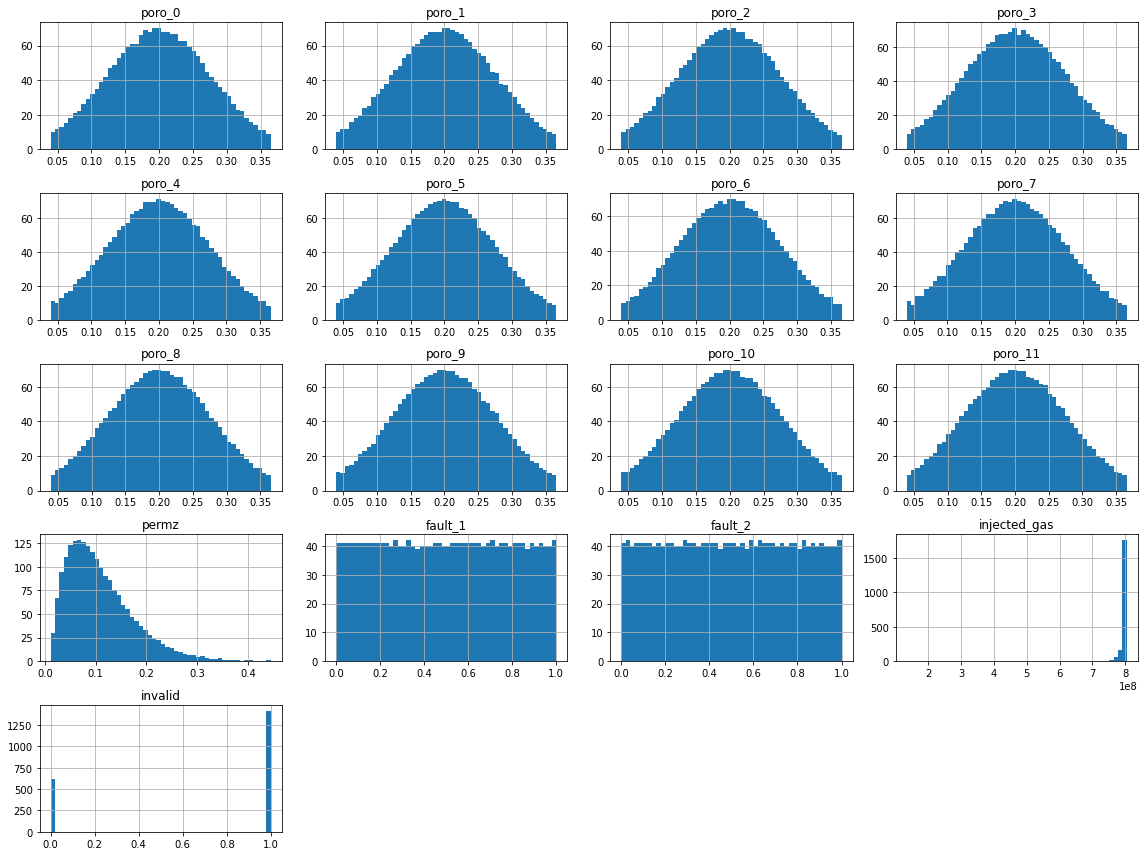

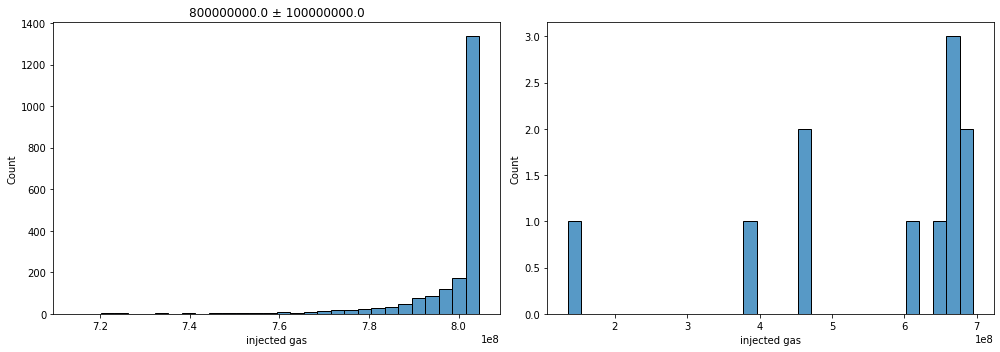

In [71]:
df.hist(bins=50, figsize=(16, 12))
plt.tight_layout()
plt.show()

common_val = 8e8
window = 1e8
mask_common = (df['injected_gas'] >= common_val - window) & (df['injected_gas'] <= common_val + window)
df_common = df[mask_common]
df_other = df[~mask_common]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_common['injected_gas'], bins=30, ax=axs[0])
axs[0].set_title(f"{common_val} ± {window}")
axs[0].set_xlabel("injected gas")

sns.histplot(df_other['injected_gas'], bins=30, ax=axs[1])
axs[1].set_xlabel("injected gas")

plt.tight_layout()
plt.show()

In [38]:
df.groupby('invalid').mean().T

invalid,0,1
poro_0,1.594984e-01,2.183096e-01
poro_1,1.769460e-01,2.107913e-01
poro_2,1.803199e-01,2.091117e-01
poro_3,1.813853e-01,2.090106e-01
poro_4,1.937247e-01,2.035771e-01
poro_5,1.991297e-01,2.005492e-01
poro_6,2.001720e-01,2.008737e-01
poro_7,1.919462e-01,2.046552e-01
poro_8,1.868399e-01,2.063389e-01
poro_9,1.913959e-01,2.045057e-01


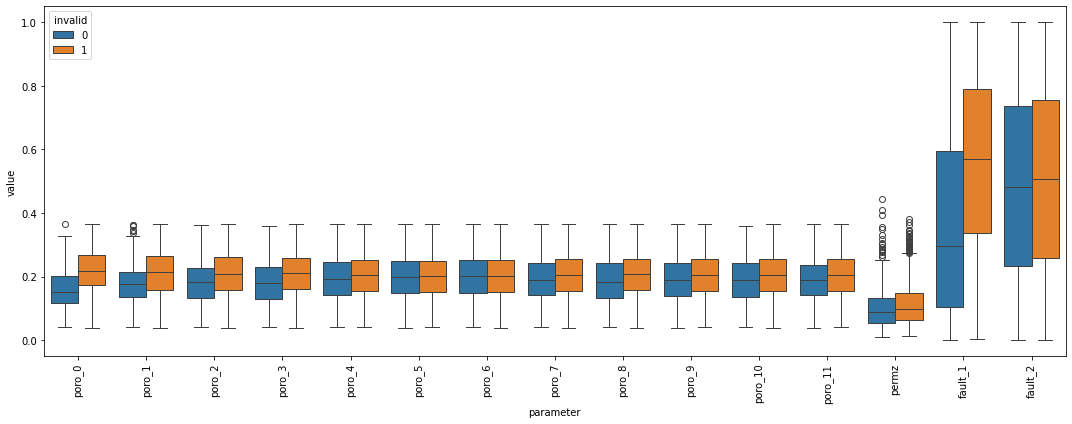

In [39]:
df_filtered = df.drop(columns=['injected_gas'])  # Keep only inputs + 'invalid'
df_melted = df_filtered.melt(id_vars='invalid', var_name='parameter', value_name='value')

plt.figure(figsize=(15, 6))
sns.boxplot(data=df_melted, x='parameter', y='value', hue='invalid')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Check if there are inputs with little influence and/or clear correlations

- plot gas vs. each input
- plot basic correlations, e.g. assuming linear or monotonic behaviour (to account for strong nonlinear behaviour need to move to more advanced methods)
- plot basic importance of each feature, e.g. keep one feature the same, vary the others plot output

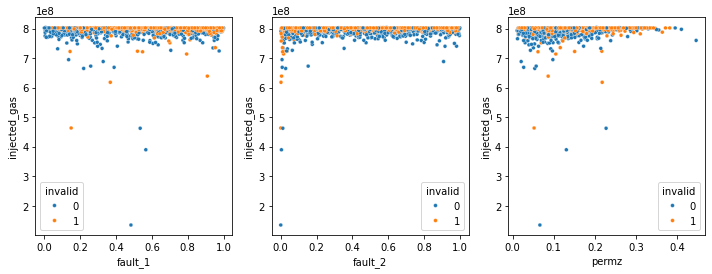

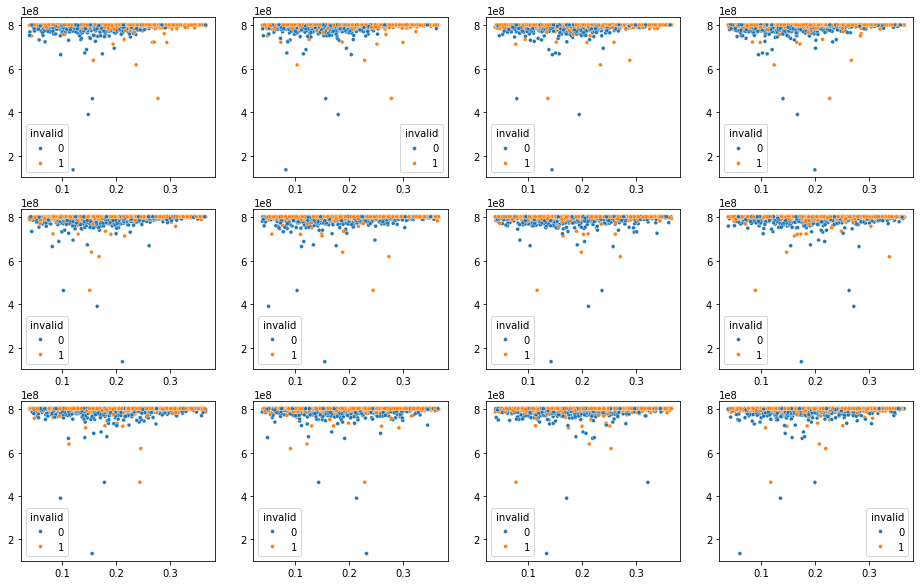

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.scatterplot(data=df, x='fault_1', y='injected_gas', hue='invalid', ax=axs[0], s=15)
sns.scatterplot(data=df, x='fault_2', y='injected_gas', hue='invalid', ax=axs[1], s=15)
sns.scatterplot(data=df, x='permz', y='injected_gas', hue='invalid', ax=axs[2], s=15)

fig, axs = plt.subplots(3, 4, figsize=(16, 10))  # 3 rows × 4 cols = 12 plots
axs = axs.flatten()  # flatten to 1D list for indexing
for i in range(12):
    ax = axs[i]
    sns.scatterplot(data=df, x=f'poro_{i}', y='injected_gas', hue='invalid', ax=ax, s=15)
    ax.set_xlabel('')
    ax.set_ylabel('')

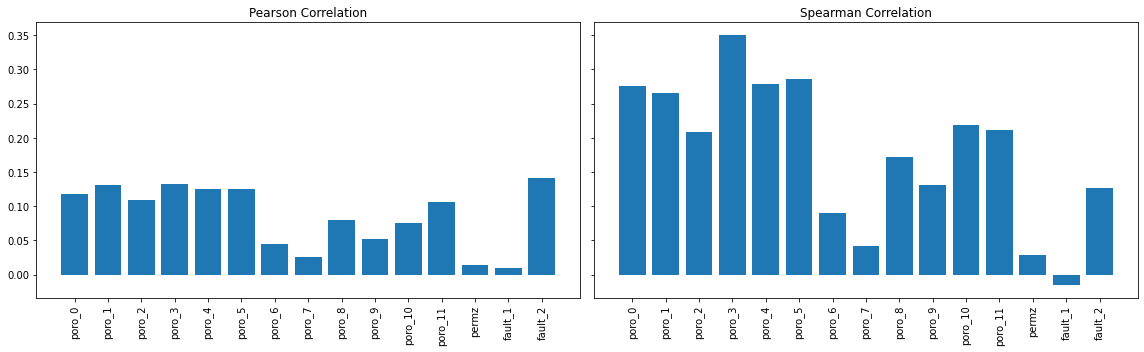

In [41]:
correlations = df.corr(numeric_only=True)['injected_gas'].drop('injected_gas')
correlations = pd.Series(correlations.sort_values(ascending=False), index=param_names)

from scipy.stats import spearmanr
spearman_corrs = []
for col in param_names:
    corr, _ = spearmanr(df[col], df['injected_gas'])
    spearman_corrs.append(corr)
spearman_corrs = pd.Series(spearman_corrs, index=param_names)

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
# Check for linear correlation
axs[0].bar(correlations.index, correlations.values)
axs[0].set_title("Pearson Correlation")
axs[0].tick_params(axis='x', rotation=90)

# Check for monotonic relations
axs[1].bar(spearman_corrs.index, spearman_corrs.values)
axs[1].set_title("Spearman Correlation")
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

The correlation values being around 1/n_inputs means none have a clear linear/monotonic relation to the outputs.

#### Sensitivity analysis

- Try sensitivity analysis by looking at Sobol indices
- Requires surrogate since the above points aren't suitable to use directly
- Alternative is producing the Sobol points with SALib rather than scipy.stats

- Try speeding up by moving to MLQMC
    - For extending to multilevel setting we need some implementation of MLQMC. Best to start from: https://bitbucket.org/pefarrell/pymlmc/src/master/

In [29]:
X = np.array(samples)
Y = np.array([f[0] for f in feval])

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
n_features = X.shape[1]
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(n_features), length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5)
gp.fit(X_scaled, Y)

#Sanity check the surrogate, R2 close to one means good fit
Y_train_pred = gp.predict(X_scaled)
r2 = r2_score(Y, Y_train_pred)
print(f"R2 score: {r2:.4f}")

/home/anne/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 13 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


R2 score: 1.0000


In [32]:
# Calculate sobol indices by using the surrogate
param_names = [f"x{i+1}" for i in range(n_features)]
problem = {
    'num_vars': n_features,
    'names': param_names,
    'bounds': [[0, 1]] * n_features
}

N = 4096
X_sobol = sobol_sample.sample(problem, N, calc_second_order=True)
Y_sobol = gp.predict(X_sobol)
Si = sobol.analyze(problem, Y_sobol, calc_second_order=True, print_to_console=False)

/home/anne/.local/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


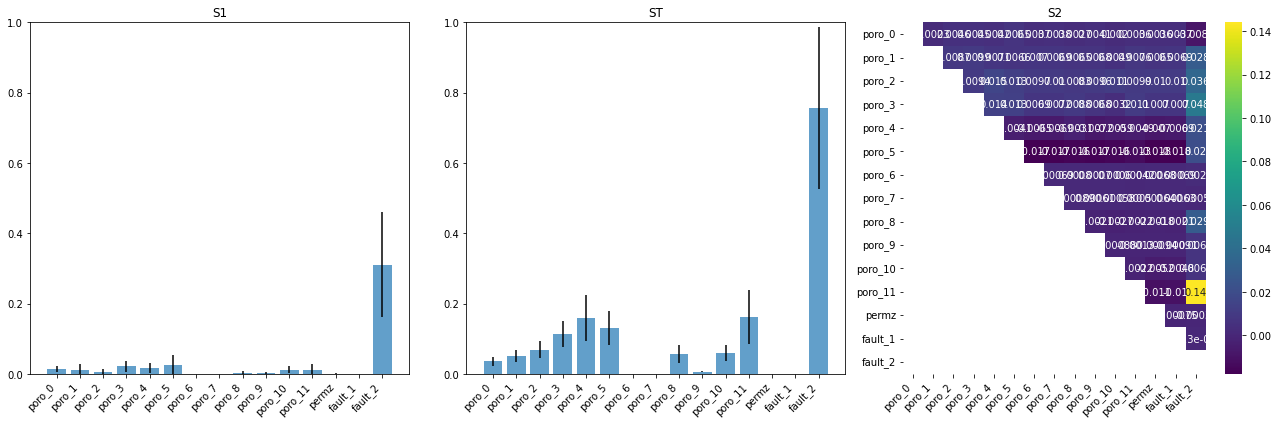

In [59]:
# Plot sobol indices
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.bar(param_names, Si['S1'], yerr=Si['S1_conf'], alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.title("S1")
plt.ylim(0, 1)
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.bar(param_names, Si['ST'], yerr=Si['ST_conf'], alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.title("ST")
plt.ylim(0, 1)
plt.tight_layout()

plt.subplot(1, 3, 3)
s2_matrix = Si['S2']
mask = np.tril(np.ones_like(s2_matrix, dtype=bool))
sns.heatmap(s2_matrix, xticklabels=param_names, yticklabels=param_names, cmap='viridis', annot=True)

plt.title('S2')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()